In [1]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, html, dcc, callback 
from dash.dependencies import Input, Output 
from skimage import io
import zarr 

In [2]:
##Importing the data

track_df = pd.read_pickle('/Users/apple/Desktop/Akamatsu_Lab/Lap_track/Final/test_data/datasets/track_df_cleaned_final_full.pkl')
filtered_tracks = pd.read_pickle('/Users/apple/Desktop/Akamatsu_Lab/Lap_track/Final/test_data/datasets/filtered_tracks_final.pkl')

zarr_arr = zarr.open(store = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/Final/test_data/zarr_file/all_channels_data', mode = 'r')

##Generate the unique number of tracks 

unique_tracks = filtered_tracks['track_id'].unique()

In [3]:
track_df.columns

Index(['frame', 'c3_gaussian_amp', 'c3_mu_x', 'c3_mu_y', 'c3_mu_z',
       'c3_sigma_x', 'c3_sigma_y', 'c3_sigma_z', 'tree_id', 'track_id',
       'c3_mean_amp', 'c3_voxel_sum', 'c3_voxel_sum_adjusted', 'c3_peak_amp',
       'c3_peak_x', 'c3_peak_y', 'c3_peak_z', 'c2_amp', 'c2_peak_amp',
       'c2_peak_x', 'c2_peak_y', 'c2_peak_z', 'c2_peak_mean', 'c2_voxel_sum',
       'c2_voxel_sum_adjusted', 'c2_gaussian_amp', 'c2_mu_x', 'c2_mu_y',
       'c2_mu_z', 'c2_sigma_x', 'c2_sigma_y', 'c2_sigma_z', 'c1_amp',
       'c1_peak_amp', 'c1_peak_x', 'c1_peak_y', 'c1_peak_z', 'c1_voxel_sum',
       'c1_voxel_sum_adjusted', 'c1_gaussian_amp', 'c1_mu_x', 'c1_mu_y',
       'c1_mu_z', 'c1_sigma_x', 'c1_sigma_y', 'c1_sigma_z'],
      dtype='object')

In [4]:
zarr_arr.shape

(130, 3, 75, 258, 275)

In [5]:
import plotly.graph_objects as go
import pandas as pd

def plot_track_movement(track_id, dataframe):
    # Filter the dataframe for the given track_id
    track_data = dataframe[dataframe['track_id'] == track_id]
    
    # Sort the data by frame to ensure the lines connect in the correct order
    track_data = track_data.sort_values('frame')
    
    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=track_data['c3_mu_x'],
        y=track_data['c3_mu_y'],
        z=track_data['c3_mu_z'],
        mode='lines+markers+text',  # This uses both lines and markers to plot the points
        marker=dict(
            size=4,  # Adjust the size of markers
            color=track_data['frame'],  # Color points by frame for visual distinction of time
            colorscale='Viridis',  # Color scale can be adjusted
            colorbar=dict(title='Frame'), showscale=False
        ),
        line=dict(
            color='darkblue',  # Line color
            width=2  # Line width
        ),
        text=track_data['frame'],  # Show frame number
        textposition="top center",  # Position the text above markers
        textfont=dict(  # Adjust text font here
            color='red'  # Set the text color to white
        )
    )])
    
    # Update the layout of the plot to add titles and axes labels
    fig.update_layout(
        title=f'Movement of Track {track_id} Over Time',
        scene=dict(
            xaxis_title='mu_x',
            yaxis_title='mu_y',
            zaxis_title='mu_z', 
            #camera=dict(
                #eye=dict(x=2, y=2, z=0.1),  # Adjust the camera's position
                #up=dict(x=6, y=6, z=1)  # Set z as 'up' direction for rotation around z-axis
            #)
        ),
        scene_aspectmode='auto',  # This can be adjusted to 'cube' or other aspect ratios
        width=600,  # Width of the figure in pixels
        height=600,  # Height of the figure in pixels
        margin=dict(l=0, r=0, t=0, b=0), # Adjust margins to fit titles and labels properly
        #dragmode = True, 
        #paper_bgcolor="rgb(0,0,0,0)", 
        #font=dict(  # Adjust text font here
            #color='white'  # Set the text color to white
        #)
    )
    
    # Show the figure
    fig.show()


In [7]:
plot_track_movement(track_id = 65, dataframe = track_df)

In [10]:
filtered_tracks.columns

Index(['track_id', 'track_length', 'track_start', 'track_end', 'c3_peak',
       'c2_peak', 'c1_peak', 'c3_peak_frame', 'c2_peak_frame', 'c1_peak_frame',
       'mean_displacement', 'mean_z', 'mean_z_displacement', 'dnm2_positive',
       'actin_positive', 'membrane_region'],
      dtype='object')

In [66]:
import plotly.graph_objects as go
import pandas as pd

def create_track_summary_table(track_id, dataframe):
    # Filter the DataFrame for the given track_id
    #track_data = dataframe[dataframe['track_id'] == track_id]
    
    # Calculate summary statistics or gather relevant track information
    summary_data = {
        'Statistic': ['Track ID', 'Total Length', 'Start Frame', 'End Frame', 'Mean Displacement', 'Mean Z', 'Mean Z Displacement', 
                     'Dynamin Positive', 'Actin Positive', 'Membrane Region'],
        'Value': [
            dataframe[dataframe['track_id'] == track_id]['track_id'].values,
            dataframe[dataframe['track_id'] == track_id]['track_length'].values,  # Total number of points for the track
            dataframe[dataframe['track_id'] == track_id]['track_start'].values,  
            dataframe[dataframe['track_id'] == track_id]['track_end'].values,  
            np.round(dataframe[dataframe['track_id'] == track_id]['mean_displacement'].values, 2),
            np.round(dataframe[dataframe['track_id'] == track_id]['mean_z'].values,2),
            np.round(dataframe[dataframe['track_id'] == track_id]['mean_z_displacement'].values,2),
            dataframe[dataframe['track_id'] == track_id]['dnm2_positive'].values,
            dataframe[dataframe['track_id'] == track_id]['actin_positive'].values,
            dataframe[dataframe['track_id'] == track_id]['membrane_region'].values,
        ]
    }

    # Convert summary data to DataFrame for easier handling in go.Table
    summary_df = pd.DataFrame(summary_data)
    
    # Create a figure with a table
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=['Statistic', 'Value'],
            font=dict(size=14),
            align="center",
            fill_color='paleturquoise',  # Background color for header
            line_color='darkslategray'  # Border color for header cells
        ),
        cells=dict(
            values=[summary_df['Statistic'], summary_df['Value']],
            align="left",
            fill=dict(color=['white', 'white']),  # Alternating row colors
            line_color='black',  # Border color for cell
            font=dict(size=14)
        ))
    ])
    
    fig.update_layout(
        width=600,  # Adjust width according to the layout
        height=450,  # Adjust height according to the number of rows
        title={
        'text': f'Summary for Track ID {track_id}',
        'y':0.9,  # Adjust vertical position
        'x':0.5,  # Center the title horizontally
        'xanchor': 'center',  # Use 'center' to center-align the title
        'yanchor': 'top',  # Use 'top' to adjust the title from the top
        'font': dict(
            #family="Arial, sans-serif",  # Set the font family
            size=20,  # Set the font size
            color="black"  # Set the font color
        )
    }
    )
    
    return fig


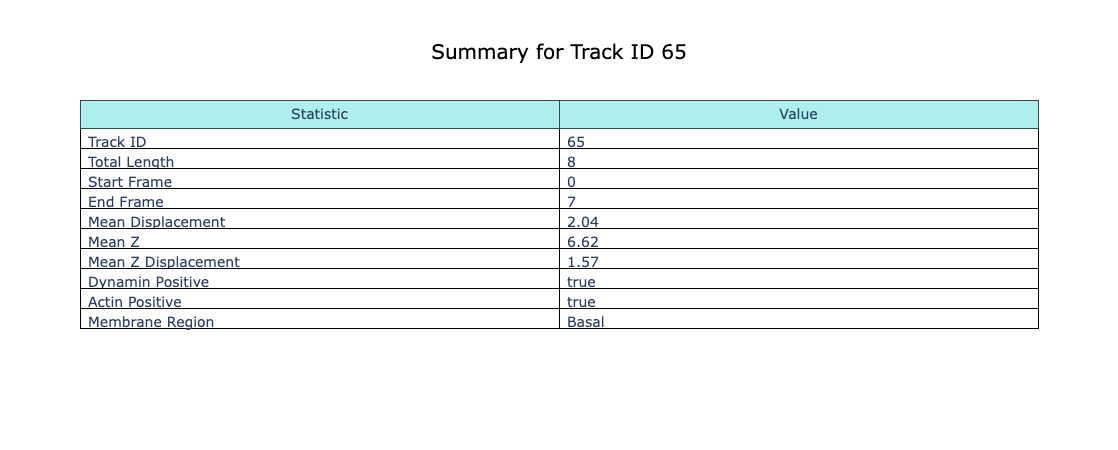

In [67]:
# Generate table for a specific track, e.g., track_id=1
table_figure = create_track_summary_table(65, filtered_tracks)
table_figure.show()